In [1]:
# Imports
from math import sqrt, exp, pi
import numpy as np
from ucimlrepo import fetch_ucirepo

In [2]:
import pickle
import os

# Check if data exists, download if required
# save to disk after download to speed up on between runs

if os.path.exists("./data.pkl"):
    with open("./data.pkl", 'rb') as fp:
        rt_iot2022 = pickle.load(fp)
else:
    rt_iot2022 = fetch_ucirepo(id=942)
    with open("./data.pkl", 'wb') as fp:
        pickle.dump(rt_iot2022, fp)

In [3]:
# Remove axes that don't contribute to data, and get labels
features = rt_iot2022.data.features
targets = rt_iot2022.data.targets

unique = features.nunique(axis=0)
for i in range(len(unique)):
    if unique[i] <= 1:
        print("Removing", features.axes[1][i])
        del features[features.axes[1][i]]
# bwd_URG_flag count is always the same, usually removed

# Get labels for data (attack or normal behavior)
normal_patterns = ["MQTT_Publish", "Thing_Speak", "Wipro_bulb", "Amazon-Alexa"]
y_bool = [int(x in normal_patterns) for x in targets.values]

/tmp/ipykernel_1051040/875652746.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if unique[i] <= 1:


Removing bwd_URG_flag_count


In [4]:
# convert string to numerical
unique_service = list(features["service"].unique())
unique_proto = list(features["proto"].unique())
for i in range(len(features["service"])):
    features.loc[i, "service"] = unique_service.index(features["service"][i])
    features.loc[i, "proto"] = unique_proto.index(features["proto"][i])

In [5]:
# use only continous vars
continuous_vars = rt_iot2022.variables[rt_iot2022.variables['type'] == "Continuous"]['name'].tolist()
features = features[continuous_vars]

In [6]:
# fit all data from -1 to 1
def normalize_axis(axis):
    return (axis - axis.min()) / (axis.max() - axis.min())

X = features.values
X = X.T
for idx in range(len(X)):
    X[idx] = normalize_axis(X[idx]) 
X = X.T
X = X.astype('float64')

X.shape

(123117, 57)

In [7]:
# Split data into train/test sets
y = np.array(y_bool)
np.random.seed(2)

test_split = .2
test_samples = int(len(X) * test_split)
perm  = np.random.permutation(len(X))
X = X[perm]
y = y[perm]

x_train = X[0:test_samples]
y_train = y[0:test_samples]
x_test  = X[test_samples:]
y_test  = y[test_samples:]

In [8]:
from logistic_reg import LogisticReg

model = LogisticReg()
model.fit(x_train, y_train, 500, 30)

In [12]:
import time


start = time.time()
predicted = model.predict(x_test)
print(f"finished in {time.time() - start}")

true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0
for i in range(len(predicted)):
    if predicted[i] == 1:
        if predicted[i] == y_test[i]:
            true_positive += 1
        else:
            false_positive += 1
    elif predicted[i] == 0:
        if predicted[i] == y_test[i]:
            true_negative += 1
        else:
            false_negative += 1

pos_acc = true_positive / (true_positive + false_positive)
neg_acc = true_negative / (true_negative + false_negative)

print(f"pos_acc: {pos_acc}, neg_acc: {neg_acc}")

print("Naive bayes accuracy is:", (true_positive + true_negative)/len(predicted))
print("Balanced Acc is: ", (pos_acc+neg_acc)/2)



finished in 0.05266427993774414
pos_acc: 0.8671145949981336, neg_acc: 0.991637995853175
Naive bayes accuracy is: 0.9780900359412756
Balanced Acc is:  0.9293762954256544


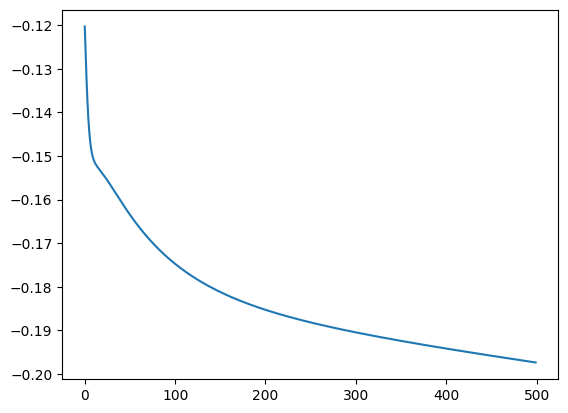

In [10]:
import matplotlib.pyplot as plt

plt.plot(model.loss)

In [11]:
# Accuracy seems too high, sanity check to make sure labels are not leaked

for axis, _ in enumerate(x_test.T):
    corrmat = np.corrcoef(x_test.T[axis], y_test)
    # print(corrmat[0][1], corrmat[1][0])
    if (corrmat[0][1] > .7):
        print("corr is ", corrmat[0][1], "at axis ", axis)
